# VaR et CVaR

In [1]:
#Importer les librairies
import numpy as np 
import pandas as pd
import datetime as dt 
import yfinance as yf 
import matplotlib.pyplot as plt 
import scipy as sci 
from scipy import stats

***Var***
> Définition : **Var** est une mesure du risque en finance, il sert à déterminer la perte maximale potentielle sur une période pour certain niveau de confiance.

***CVaR***
>Définition : **CVaR** est la moyenne des pertes aux quelles on s'attendre au delà de VaR

il existe trois (3) méthodes pour les calculer : 
- Historique
- Paramétrique
- Monte Carlo 

[VaR](https://www.investopedia.com/terms/v/var.asp) 
[CVaR](https://www.investopedia.com/terms/c/conditional_value_at_risk.asp)
[Vidéo Youtube](https://www.youtube.com/watch?v=2QJykxUNb6I&t=357s)

In [2]:
#Paramètre 
years = 10 

#EndDate = dt.datetime.now()
#StartDate = EndDate - dt.timedelta(days=365*years)
EndDate = "2024-12-01"
StartDate = "2010-01-01"
#liste des tickers 
Tickers = ["SPY", "BND","QQQ","VTI","GLD"]

##### Télécharger les données sur Yahoo Finance

Ici, nous utliliserons les prix journaliers. Le **Adjusted Close Price** inclut les changements de prix, les dividendes, il permet une analyse plus précise.  

[*********************100%%**********************]  5 of 5 completed


<Axes: xlabel='Date'>

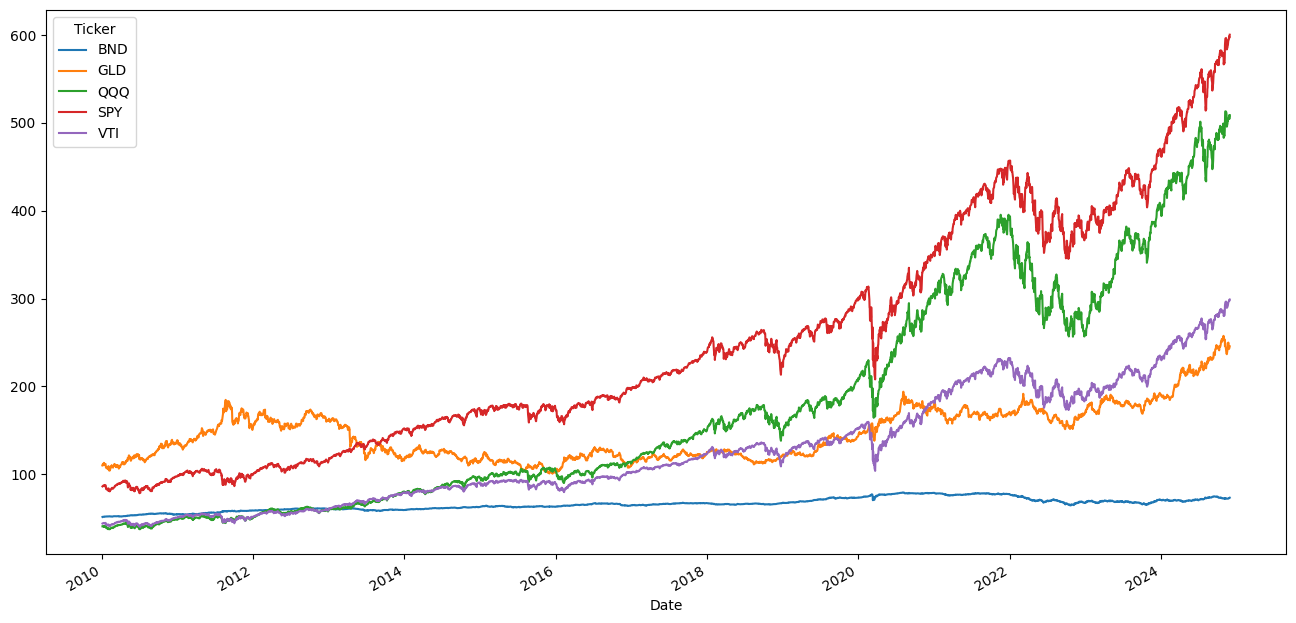

In [3]:
df = yf.download(Tickers, start=StartDate,end=EndDate)["Adj Close"]
df.plot(figsize=(16,8))

In [17]:
for col in df.columns :
    rendement = ((df[col].iloc[-1] -df[col].iloc[0])/ df[col].iloc[0])*100
    print(col,round(rendement,2),'%')

BND 42.72 %
GLD 123.67 %
QQQ 1155.16 %
SPY 598.07 %
VTI 583.23 %


#### Calcul des rendements

<Axes: xlabel='Date'>

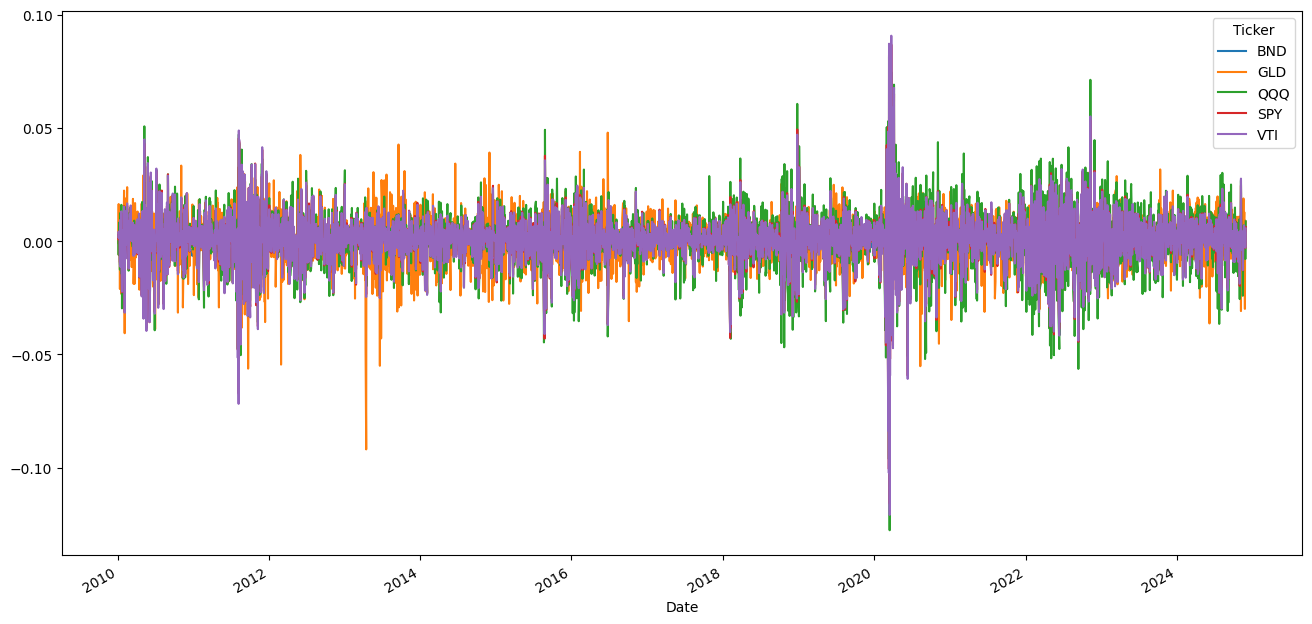

In [4]:
Rdt_df = np.log(df/df.shift(1))
Rdt_df = Rdt_df.dropna()
Rdt_df.plot(figsize=(16,8))

In [5]:
#X-Day
days = 30
#Niveau de confiance = 95%
NC = 0.95
#fenètre de calcul
Range_rdt = Rdt_df.rolling(window=days).sum()
Range_rdt = Range_rdt.dropna()
Range_rdt

Ticker,BND,GLD,QQQ,SPY,VTI
Date,,,,,
2010-02-17,0.009076,-0.005022,-0.040669,-0.027463,-0.023123
2010-02-18,0.004768,0.002549,-0.034407,-0.024229,-0.021257
2010-02-19,0.005147,-0.018464,-0.028802,-0.022861,-0.019101
2010-02-22,0.005529,-0.015917,-0.031462,-0.026893,-0.024853
2010-02-23,0.008304,-0.031746,-0.052708,-0.042435,-0.040255
...,...,...,...,...,...
2024-11-22,-0.013677,0.017646,0.024883,0.027115,0.035705
2024-11-25,-0.003811,-0.010625,0.018106,0.022356,0.032819
2024-11-26,-0.009511,-0.012151,0.036918,0.035364,0.043361


## Méthode Historique 
> Cette méthode repose sur l'analyse de données historiques pour prédire les risques potentiels futurs. On reclasse simplement les rendements historiques de manière croissante du pire au meilleur. Pour utiliser cette méthode, on définit une période de temps et un niveau de confiance. La fonction <span style="color:yellow;">Historical_VaR</span> a pour argument le vecteur des rendements et le niveau de confiance. La fonction de numpy *.percentile()* permet de retrouver le 5e percentile du vecteur de rendements. 

[J.A DATATECH CONSULTING](https://www.youtube.com/watch?v=hCRLJvc2o7g)

[Ryan O'Connell](https://www.youtube.com/watch?v=jZJsPi4j7wQ&t=446s)

In [6]:
def Historical_VaR(Data,x):
    VaR = -np.percentile(Data, 100-(x*100))
    CVaR = Data[Data<=VaR].mean()
    Result = (VaR, CVaR)
    return Result

In [7]:
for ti in Tickers:
    print("VaR de", ti,"=", Historical_VaR(Range_rdt[ti],NC)[0])
    print("CVaR de", ti, "=", Historical_VaR(Range_rdt[ti],NC)[1])
    print("--"*30)

VaR de SPY = 0.07234306409049149
CVaR de SPY = 0.009601194122908554
------------------------------------------------------------
VaR de BND = 0.026268643415417254
CVaR de BND = 0.0011160381614100333
------------------------------------------------------------
VaR de QQQ = 0.08637463482248395
CVaR de QQQ = 0.010760665209510321
------------------------------------------------------------
VaR de VTI = 0.0758452514918552
CVaR de VTI = 0.009447567011397281
------------------------------------------------------------
VaR de GLD = 0.07235863060026076
CVaR de GLD = -0.0024393184117831998
------------------------------------------------------------


## Méthode paramétrique 
> Aussi appelé la méthode Variance-covariance. Avec cette méthode, on se sert du moyenne et de l'écart-type ou de la variance pour déterminer la perte maximale potentielle. On pose ainsi l'hypothèse que les rendements sont distribués suivant une loi normale.


In [8]:
#Moyenne et Écart-type
Moyenne = Range_rdt.mean()
Ecart_type = Range_rdt.std()

In [9]:
Moyenne["SPY"]

np.float64(0.015640427929929965)

In [10]:
def Parametric_VaR_CVaR(Data,x):
    VaR = Data.mean()-stats.norm.ppf(x)*Data.std()
    CVaR = Data.mean()-((stats.norm.pdf(stats.norm.ppf(x))/(1-x))* Data.std())
    Results = (VaR, CVaR)
    return Results

In [11]:
for ti in Tickers:
    print("La VaR de",ti,"=", Parametric_VaR_CVaR(Range_rdt[ti],NC)[0])
    print("La CVaR de",ti,"=",Parametric_VaR_CVaR(Range_rdt[ti],NC)[1])
    print("--"*30)

La VaR de SPY = -0.06693288593566599
La CVaR de SPY = -0.08790983896194608
------------------------------------------------------------
La VaR de BND = -0.023260060454973686
La CVaR de BND = -0.02985928644413163
------------------------------------------------------------
La VaR de QQQ = -0.07755981603551558
La CVaR de QQQ = -0.10248398167278279
------------------------------------------------------------
La VaR de VTI = -0.07093725011320504
La CVaR de VTI = -0.09287498785350622
------------------------------------------------------------
La VaR de GLD = -0.07528085944158018
La CVaR de GLD = -0.09609538762795712
------------------------------------------------------------


## Méthode de Monte Carlo 
> La méthode de Monte Carlo est basé sur la simulaltion. on simule différents scénarios. Elle emploie l'echantillonage aléatoire et les modèles statistiques pour estimer la perte maximale potentielle. En effet, à partir des niveaux actuels, on simules les rendements en fonction des facteurs de risque sous jacent le modèle. La méthode de Monte Carlo est utilisé pour estimer des valeurs par les principes de la statistique inférentielle

In [12]:
mu = Rdt_df.mean()
sigma = Rdt_df.std()

In [13]:
print(mu,sigma)

Ticker
BND    0.000095
GLD    0.000215
QQQ    0.000674
SPY    0.000518
VTI    0.000512
dtype: float64 Ticker
BND    0.003056
GLD    0.009790
QQQ    0.012905
SPY    0.010781
VTI    0.011052
dtype: float64


In [14]:
print(mu['BND'], sigma["BND"])

9.480605431959856e-05 0.0030563862621955447


In [15]:
def MC_VaR_CVaR(returns, alpha, it):

    sims = np.random.normal(returns.mean(), returns.std(), it)
    sorted_sims = np.sort(-sims)
    MC_VaR = np.percentile(sorted_sims,(1-alpha)*100)
    MC_CVaR = sorted_sims[sorted_sims <= MC_VaR].mean()

    return MC_VaR, MC_CVaR

In [16]:
for ti in Tickers:
    print("La VaR de",ti,"=", MC_VaR_CVaR(Rdt_df[ti],NC,1000)[0])
    print("La CVaR de",ti,"=",MC_VaR_CVaR(Rdt_df[ti],NC,1000)[1])
    print("--"*30)

La VaR de SPY = -0.018194598700457223
La CVaR de SPY = -0.023966617072963423
------------------------------------------------------------
La VaR de BND = -0.005525100706413472
La CVaR de BND = -0.006143085040197278
------------------------------------------------------------
La VaR de QQQ = -0.02082300577184391
La CVaR de QQQ = -0.027748810937223447
------------------------------------------------------------
La VaR de VTI = -0.018967637885465714
La CVaR de VTI = -0.02336472734758188
------------------------------------------------------------
La VaR de GLD = -0.016280263082705245
La CVaR de GLD = -0.019984742913663967
------------------------------------------------------------
